In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM

In [79]:
#imports utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [80]:
from PIL import Image
from skimage import transform
import cv2
import mediapipe as mp
import time
import os

In [81]:
mp_holistic = mp.solutions.holistic#modelo holistico
mp_drawing = mp.solutions.drawing_utils#utilidades de dibujo

## Modelo de Regresion Lineal con RNN

### Arquitectura Inicial

![title](rnn_reg_lineal.png)

**Lectura de archivo con observaciones**

In [82]:
df_reg = pd.read_csv('concrete_data.csv')

In [10]:
#validamos las dimensiones del archivo
df_reg.shape

(1030, 9)

In [11]:
#Vemos si existe variables nulas o vacias
df_reg.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [12]:
df_reg.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [84]:
#Estramos las variables independendientes
y_cement = df_reg[['Strength']]
x_cement = df_reg.drop('Strength', axis=1)

In [85]:
#Normalizamos la data
x_cement = (x_cement - x_cement.mean()) / x_cement.std()
x_cement.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
count,1.030000e+03,1.030000e+03,1030.000000,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03
mean,-4.139084e-16,-1.793603e-16,0.000000,-1.379695e-16,-1.931572e-16,7.243397e-16,-4.759946e-16,4.139084e-17
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.714421e+00,-8.564718e-01,-0.846733,-2.798851e+00,-1.038638e+00,-2.211064e+00,-2.239829e+00,-7.070160e-01
25%,-8.496407e-01,-8.564718e-01,-0.846733,-7.805147e-01,-1.038638e+00,-5.262618e-01,-5.317114e-01,-6.120340e-01
50%,-7.911350e-02,-6.014861e-01,-0.846733,1.607513e-01,3.269920e-02,-6.326279e-02,7.383152e-02,-2.795973e-01
75%,6.586406e-01,8.003558e-01,1.001791,4.885554e-01,6.688058e-01,7.264077e-01,6.288606e-01,1.636517e-01
max,2.476712e+00,3.309068e+00,2.279976,3.064159e+00,4.351528e+00,2.213149e+00,2.731735e+00,5.055221e+00


In [86]:
#Separamos para entrenar y luego para valiar
x_train, x_test, y_train, y_test = train_test_split(x_cement,y_cement, test_size = 0.25)

In [87]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(772, 8) (772, 1)
(258, 8) (258, 1)


In [88]:
def regression_model(n_neu_1, act_1, n_neu_2, act_2, opti, loss_fun,n_cols):
    # create model
    model = Sequential()
    model.add(Dense(n_neu_1, activation=act_1, input_shape=(n_cols,)))
    model.add(Dense(n_neu_2, activation=act_2))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer=opti, loss=loss_fun)
    return model

## Checkpoint para regresion

In [50]:
# checkpoint
#filepath="concrete_weights/improvement-{epoch:02d}-{loss:.2f}.hdf5"
filepath="concrete_weights/"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#monitor='val_accuracy'
early_stop = EarlyStopping(monitor='loss', patience=3)
callbacks_list = [checkpoint,early_stop]

In [94]:
def get_reg_model(n_neu_1, act_1, n_neu_2, act_2, optimizador, loss_fun,x_test,y_test,batch_size,epochs):
    model = regression_model(n_neu_1,act_1,n_neu_2,act_2,optimizador,loss_fun,x_test.shape[1])
    model.fit(x_test, y_test, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)
    return model
#model.fit(x_test, y_test, validation_split=0.15, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

In [51]:
#model = regression_model(50,'relu',50,'relu','adam','mean_squared_error',8)
n_model = get_reg_model(50,'relu',50,'relu','adam','mean_squared_error',x_test,y_test,32,1000)


Epoch 00001: loss improved from inf to 1477.34033, saving model to concrete_weights\
INFO:tensorflow:Assets written to: concrete_weights\assets

Epoch 00002: loss improved from 1477.34033 to 1436.93884, saving model to concrete_weights\
INFO:tensorflow:Assets written to: concrete_weights\assets

Epoch 00003: loss improved from 1436.93884 to 1392.11877, saving model to concrete_weights\
INFO:tensorflow:Assets written to: concrete_weights\assets

Epoch 00004: loss improved from 1392.11877 to 1339.81055, saving model to concrete_weights\
INFO:tensorflow:Assets written to: concrete_weights\assets

Epoch 00005: loss improved from 1339.81055 to 1274.84485, saving model to concrete_weights\
INFO:tensorflow:Assets written to: concrete_weights\assets

Epoch 00006: loss improved from 1274.84485 to 1196.62817, saving model to concrete_weights\
INFO:tensorflow:Assets written to: concrete_weights\assets

Epoch 00007: loss improved from 1196.62817 to 1106.15381, saving model to concrete_weights\
IN

KeyboardInterrupt: 

In [46]:
x_test.shape

(258, 8)

In [43]:
#cargando checkpoints
model.load_weights(filepath)

In [52]:
def return_strenght_cemnt(x_vars,model):
    return model.predict(x_vars)

In [53]:
def return_mean_squared_error(y_hat, y_real):
    return np.mean(np.absolute(y_hat - y_real))

In [55]:
y_hat = model.predict(x_test)
y_hat.shape

(258, 1)

In [59]:
error = return_mean_squared_error(y_hat, y_test.values)
print(error)

7.565753690586534


In [92]:
exp_1_r = [1490.5670,1356.9789,1124.6171,790.6671,455.4922,263.7855,213.0409,198.4547,188.6324,181.4568,176.1796,171.2065,166.8432,163.8811,159.7790,157.0034,153.7771,151.5060,148.9104,146.8208,145.0730,142.6784,141.2441,139.0019,137.9556,135.5893,134.3469,132.3927,130.5601,128.9244,127.0583,125.6221,124.5607,123.1828,121.7346,119.4366,118.3570,116.7044,115.2514,113.8839,112.0075,110.2078,108.7975,106.4624,104.4252,102.3203,100.3573,98.6429,96.3240,93.3298,90.5643,89.2185,85.7060,83.1267,80.8345,77.7579,75.9874,73.8441,72.2080,70.2772,67.8467,66.0055,63.6846,62.1068,60.3484,59.0547,57.5134,56.1080,54.2909,54.0561,51.4943,50.2768,49.5558,48.3045,46.8374,46.4173,44.9460,43.9535,43.8612,42.4254,41.4640,41.0550,40.3439,39.7285,39.2566,38.5317,38.0839,37.4466,37.1893,36.6934,36.0174,35.7543,35.2130,35.0467,34.6929,34.6848,34.1239,33.4086,32.8645,32.8334,32.7423,32.1319,31.6804,31.5793,31.2623,31.1069,31.0643,31.0399,30.3001,29.6501,29.9895,29.4135,29.2691,29.0260,28.8262,28.3112,28.4667,28.0349,27.8736,28.2525,27.2984,27.2307,27.0843,26.8368,26.6953,26.8691,27.1011,26.2459,25.9066,25.6570,25.6818,25.8807,25.3876,25.5529,25.1122,25.3043,24.8955,24.9334,24.7639,24.5162,24.2904,24.0764,24.2653,23.8867,23.7705,23.3991,23.7896,23.1757,23.1510,23.5811,22.8137,22.6071,22.7673,22.5586,22.6354,22.2601,22.1634,21.8250,21.9385,21.7962,21.7101,21.8264,21.6343,21.4682,21.5563,21.4995,21.2849,21.1705,21.3391,20.8048,20.9135,21.1068,20.5711,20.5063,21.5505,20.4207,20.6670,20.5924,20.2471,20.1870,20.0527,20.3309,21.2051,20.4047,20.0306,19.5542,19.3832,19.2022,19.4103,19.2942,19.0699,19.5112,18.9791,19.1537,18.7842,18.7210,19.1468,18.9062,20.3509,19.5966,18.4495,18.4513,18.4236,18.9414,18.3393,18.5495,18.2971,18.2001,17.8682,17.8787,18.0830,18.1684,17.8004,17.7273,17.8658,17.7462,17.6121,17.6112,17.5427,17.4883,17.5480,17.4361,17.2564,18.0219,17.9305,17.1068,17.3069,16.9252,17.1832,16.8197,17.2601,17.3484,16.9599,16.9365,16.9515,16.7710,16.5316,16.6348,16.8376,16.8045,16.2271,16.6212,16.6932,16.0770,16.5949,16.3277,16.1983,16.1448,16.3974,16.1416,16.0967,16.0308,16.3383,15.9673,15.9055,16.0771,15.9554,16.3545,15.8093,15.5123,15.8647,15.9609,15.5123,15.3848,15.7746,16.0325,15.4680,15.5703,15.2815,15.4716,15.3548,15.2263,15.0509,15.4601,15.6009,15.4062,15.9038,15.4793,14.9049,15.1727,15.2915,14.8581,14.9393,14.6604,15.1791,14.7297,14.8984,14.9271,15.0543,14.8011,14.5438,14.6301,14.5611,14.7118,14.8132,14.3023,14.4018,14.5238,14.6427,14.4316,14.5324,14.5753,14.1463,14.3455,14.2000,14.2605,14.0986,14.1470,14.0206,13.9591,13.9977,14.0078,14.0519,14.2563,13.8564,13.8778,14.0736,14.1165,14.0705,14.0851,14.2402,13.8925,13.5465,13.4115,13.7888,13.9165,13.7512,13.5831,13.4283,13.4896,13.4759,13.6813,13.3501,13.3738,13.3561,13.3116,13.4126,13.3599,13.2532,13.4829,13.3713,13.5801,13.3873,13.3515,13.2551,13.1686,12.9306,13.0291,13.9368,14.3580,13.0345,13.0462,12.8998,12.7948,13.0120,12.9164,12.9538,12.6899,12.6415,12.7198,12.9468,12.8090,12.6576,12.9747,12.8670,12.9866,12.5829,12.6078,12.7361,12.4124,12.4468,12.4869,13.0308,12.8028,12.6293,12.5013,12.4604,12.8178,12.3854,12.5126,12.6051,12.5051,12.2990,12.5344,12.1617,12.1754,12.1723,12.2922,12.0421,12.3815,12.0337,12.0736,12.1698,11.9200,11.9414,12.3492,12.2026,12.5714,12.3656,12.0169,12.0206,12.3665,12.1427,12.2307,12.0082,11.8861,11.8316,11.7370,11.6366,11.5820,12.3654,11.7475,11.8117,11.4444,11.4228,11.5817,11.6194,11.7244,12.2445,12.5039,12.1528,11.5898,11.6461,11.4881,11.1045,11.4069,11.6129,11.6832,11.2028,11.2026,11.4187,11.7131,11.4898,11.1959,11.3582,11.1621,11.3023,11.0976,11.3743,10.9854,11.2510,11.2361,11.2375,11.0849,11.0079,10.9398,11.1377,11.4773,10.8413,10.6417,11.2304,11.1756,11.0515,10.9127,11.0591,11.1570,11.7016,10.8556,10.9480,10.7585,11.1895,11.0782,11.0380,11.0958,11.1745,11.0624,10.8100,10.4545,10.6188,10.9918,10.5507,10.6715,10.6296,10.5985,10.7397,10.6697,11.4072,11.2383,11.0366,10.6426,10.9207,10.6056,10.3694,10.7822,10.7317,10.7059,10.6062,11.0391,10.4409,10.3882,10.4061,10.3302,10.2432,10.3387,10.4729,10.7045,11.0551,10.3425,10.5593,10.2507,10.2721,10.3598,10.3398,10.2907,10.1984,10.3898,10.4751,10.1212,10.2431,10.5634,10.1935,10.2117,10.2843,10.1653,10.2418,10.3676,10.0975,10.2147,9.9512,10.5030,10.1976,10.2035,10.0308,10.0339,10.6180,10.4252,9.7819,9.8567,9.8212,10.3017,10.1866,9.8482,9.6875,9.9860,9.9077,9.6834,9.8446,9.8696,10.1926,10.0049,9.9984,10.0918,9.6728,9.8646,9.8661,10.2465,9.7970,9.7183,9.7960,9.7559,9.8253,9.5081,9.7771,9.7346,10.2317,9.7528,9.5578,10.0060,9.6372,9.6569,9.2843,9.5233,9.5345,9.3785,9.4794,9.7896,9.5473,9.8860,9.3691,9.4607,9.4082,9.4983,10.1114,9.5094,9.4184,9.6739,9.7624,9.3001,9.3258,9.6478,9.1631,9.2019,9.5095,9.3151,9.2651,9.3024,9.1102,9.1042,9.3438,9.1020,9.3908,9.1865,9.5927,9.3740,9.2176,9.3601,9.0709,9.1853,9.1134,9.5822,10.0572,9.3097,9.7530,9.4464,9.3106,9.1818,9.2404,9.0532,9.1355,9.2554,8.8268,9.0606,9.2268,8.9218,9.3171,10.3847,9.2360,9.1983,9.2700,9.0406,9.0308,9.1047,8.8308,8.9172,8.7985,8.7895,8.7899,9.0378,9.1547,8.9749,8.8559,9.0404,9.2908,9.2972,8.7022,8.7414,8.6828,8.6092,8.9392,8.6217,8.7232,9.0672,8.5927,8.9305,9.2313,9.0865,8.8658,8.8836,8.8356,8.9379,8.5979,8.5681,8.7939,8.5955,8.4172,9.1519,8.5739,8.3904,9.2165,8.8995,8.6895,8.5476,8.4091,8.4109,8.7594,8.6980,8.5977,8.6911,8.8668,8.8071,8.7024,8.4134,8.2176,8.2733,8.4642,8.4979,8.5001,8.6364,8.1644,8.3515,8.1718,8.5744,8.8654,8.3881,8.1543,8.5636,8.3307,8.5214,8.3791,8.8408,8.7809,8.6367,8.2205,8.5764,8.1472,8.5107,8.3964,8.5074,8.2690,8.2133,8.0198,8.3904,8.1553,8.2327,8.3910,8.0826,8.5129,8.2826,8.4590,8.1784,8.2097,8.0927,8.3646,8.2444,8.3088,8.4004,8.1135,8.0799,7.9205,8.0490,7.8816,8.0985,8.0265,8.1042,8.2640,8.4496,8.0392,8.1327,7.9466,7.9965,7.9172,7.7747,8.0480,7.9865,8.0868,8.2061,7.9315,8.1552,8.0849,7.9423,7.9484,7.8247,7.8898,8.0365,8.3835,8.0780,8.1780,7.9037,7.8542,7.9550,7.7529,7.6248,7.9302,8.0260,7.7805,8.0285,8.0557,8.0610,8.0963,8.1082,8.1918,8.3104,7.7992,7.8426,8.1173,7.9979,7.7708,7.7253,7.6462,7.7380,7.6536,7.5993,7.5628,7.6314,7.8862,7.9350,8.0809,7.7359,7.8940,7.3985,8.2747,7.6923,7.9927,7.8658,7.7044,7.5614,7.5671,7.8376,7.7475,7.5155,8.2947,8.5983,7.9849,7.5733,7.7642,7.6719,7.7712,7.4857,7.3752,7.6594,7.4283,7.5088,7.8439,8.0656,7.3971,7.6246,7.3516,7.9662,8.6279,8.1389,7.5086,7.3825,7.3098,7.3426,7.3135,7.4876,7.5226,7.7030,8.1438,8.1055,8.7318,7.9642,7.8894,8.1954,7.4401,7.7164,7.3695,7.6938,7.3453,7.3468,7.3011,7.5708,7.5210,7.5346,7.4379,7.2004,7.5002,7.3596,7.1368,7.2113,7.3475,7.2811,7.3982,7.0840,7.1603,7.2062,7.2269,7.0392,7.3564,7.2636,7.4250,7.3073,7.2739,7.2109,7.0542,7.1200,7.2571,7.4010,7.2675,7.2824,7.2582,7.3013,7.4744,7.3256,7.2058,7.5085,7.0108,7.4257,7.2541,7.2998,7.0510,7.0825,7.5340,7.1419,7.8991,7.0834,7.2028,6.9517,7.2106,7.2861,7.1157,7.0582,7.4637,7.3696,7.2351,7.3200,8.0882,7.1626,7.4610,7.2923,6.8099,6.8812,6.9790,7.4795,7.0047,6.9503,7.0574,7.0495,6.9046,6.9332,7.1017,7.3843,6.8506,7.3103,6.9424,6.8100,6.9053,6.9604,6.8933,6.8000,6.8486,6.8497,6.7320,6.9134,7.1075,6.9819,6.9272,6.8849,7.1748,7.2808,7.0573,6.7620,7.0129,6.8275,6.8945,6.7648,6.9926,7.1768,6.9175,7.2949,6.7801,6.9795,7.2889,7.0193,7.1702,7.4108,6.9822,6.6413,6.7223,6.9564,7.3162,6.9677,6.7316,6.7217,6.6574,6.7046,6.5813,6.7864,6.6281,6.8214,6.9346,6.9421,7.0418,6.5362,7.1812,7.0707,7.0210,6.9015,6.6224,6.8123,6.7313,6.3939,6.6170,6.7645,7.0097,7.2515,6.8327,6.7168,6.8226,6.6317,7.4162,6.5373,6.6837,6.6512,6.5185,6.7553,6.6760,6.7511,6.8492,6.7967,6.6638,6.5953,6.7327,6.7921,6.8524,6.7408,6.5051,6.5328,6.5607,6.9079,6.7386,6.6917,6.6895,6.7387,6.6748,6.5719,6.4334,6.8348,6.7240,6.5761,6.5175,6.6397,7.1818,6.5153,6.4362,6.4613,6.5509,6.3061,6.2998,6.6570,6.4325,6.7000,6.8074,6.6444,6.2021,6.3079,6.5723,6.8468,6.4954,6.4238,6.3645,6.3554,6.6417,6.5500,6.3176,6.3647,6.4965,6.3326,6.7239,6.3066,6.2545,6.2795,6.8969,7.3138,6.7253,6.5192,6.5000,6.5692,6.4631,6.3386,6.3723,6.0943,6.9514,6.3414,6.1127,6.4910,6.3484,6.5434,6.4686,6.4999,6.2873,6.5082,6.6136,6.5944,6.3209,6.5048,6.7419,6.4131,6.4444,6.2735,6.1924,6.3595,6.5730,6.2134,6.2275,6.4805,6.0933,5.9820,6.3940,6.2782,6.0344,6.1551,6.2362,6.2983,5.9066,6.0249,6.1747,6.1085,6.3351,6.2344,6.1523,6.1482,5.9395,5.9454,6.0669,6.3171,6.2216,5.9465,6.1857,5.9722,6.3798,6.1853,6.1776,6.3108,6.2715,5.9934,6.0756,5.9688,6.1172,6.0764,6.0396,6.1576,6.1821,6.7717,6.0446,6.0665,5.9186,5.9267,6.1982,6.1585,5.8123,6.1476,5.9644,5.8020,5.9099,6.0541,6.1426,5.8090,6.0904,6.3798,6.0672,6.0857,5.7691,5.7932,6.1272,6.2102,6.0241,5.9375,6.0987,6.0502,5.8486,6.0880,5.8200,5.6283,5.8262,6.7146,5.9416,6.1889,5.9217,5.6549,5.9726,5.9830,6.2477,6.2376,6.0568,6.0439,6.1389,5.6716,5.8091,5.8478,5.7665,5.8284,5.5774,5.7101,5.9490,5.9059,6.0634,5.8260,5.9770,6.4084,5.8033,5.7834,5.6807,5.5269,5.8124,5.9756,6.2351,5.8683,6.0560,5.5819,5.7679,5.5828,5.8826,5.7761,6.2881,5.8633,5.6628,5.6780,6.1492,6.0216,6.6804,5.5776,5.4576,5.4696,5.9566,5.9402,6.1804,5.6022,5.6602,5.6880,5.5585,5.8192,5.6243,5.6742,5.8332,5.7488,6.1299,5.4618,5.5997,5.5473]
exp_2_r = [1036.4718,524.7990,443.0739,348.8844,273.6904,209.4315,99.2099,80.3275,78.3800,64.9325,59.6519,46.7863,44.9413,51.1010,48.4027,38.1740,49.3508,37.7486,37.7344,44.8071,33.3657,32.6806,45.3509,39.7052,31.9620,31.9586,34.3608,28.9723,29.3610,29.7858,23.1201,26.4845,31.5622,30.5088,28.8805,25.5864,28.9221,24.4393,23.2795,20.2475,29.3455,24.6556,23.3656,20.8572,22.8051,22.6554,24.4083,18.4256,21.2743,19.8836,23.7285,19.9627,20.1666,22.3177,16.3528,21.2492,19.4306,18.0905,17.0474,20.0497,17.8559,25.8279,17.3980,15.4715,14.6509,19.4285,15.7547,17.7237,16.5440,12.8468,16.5037,16.7902,16.0448,17.2774,15.2399,13.9431,14.3737,15.2387,13.9582,14.3662,18.5192,15.6369,16.1132,15.1601,21.6991,12.9781,13.8680,13.2995,13.5433,13.8792,11.9803,12.0484,15.1224,14.0413,12.1982,12.2538,12.7151,12.2950,14.4962,13.6509,11.5651,13.8325,14.0194,12.2373,11.1050,14.1670,10.9156,14.3627,12.5213,13.6449,12.8895,11.3376,12.2179,10.6126,11.7769,16.6787,11.5842,12.0227,11.6535,11.3884,13.9884,11.4038,12.3279,13.4673,11.8750,10.2672,13.8773,10.0745,10.6940,11.0377,9.9293,11.2917,12.1792,9.5822,10.8967,10.4096,11.1410,9.2112,9.4402,10.4853,9.8505,9.7140,10.7692,10.5956,8.8673,10.7799,13.2276,9.5663,10.1270,9.6008,10.1626,10.7888,11.3316,9.5733,10.0881,8.8919,10.0075,11.3488,9.6088,8.8382,10.2501,10.4618,9.3707,13.0680,11.7786,9.5420,9.2605,10.3080,9.0353,10.5051,9.1954,9.6569,9.4125,9.0226,9.8027,7.9319,9.0227,11.8079,9.1778,10.7553,11.1040,10.8911,8.0252,8.4534,11.5429,9.5387,7.7081,8.5921,8.3607,7.6020,10.0227,8.3832,7.8689,7.8098,12.4744,10.7468,8.4603,7.9025,7.8572,7.1172,9.0427,10.3373,9.7314,8.4914,8.3644,8.1681,12.7938,7.8786,9.3892,7.9179,7.6389,9.7967,8.3313,10.1106,10.4255,8.6156,7.4447,6.9546,7.2701,8.1391,8.5933,8.2682,10.5197,8.4738,7.7111,7.4967,9.2900,8.6511,16.6475,8.4733,8.2223,7.9748,8.6904,8.4635,8.0678,7.6419,8.1868,9.7442,7.6340,7.4931,6.4364,7.1593,7.5866,9.5271,6.0576,7.5217,9.8518,6.6818,6.5095,6.5468,6.8219,6.6578,8.4004,7.6090,8.3814,9.1413,6.9626,6.2809,7.2846,6.8309,6.4537,7.8615,9.0830,8.8389,7.4760,6.3145,7.6743,5.9472,6.6882,9.4292,6.1851,6.5882,6.8615,7.8094,7.8010,6.7363,6.1345,7.7578,8.0923,6.9908,8.7048,6.3139,6.3547,7.2913,7.5853,6.2627,5.7059,6.3276,5.6177,5.3920,6.1048,5.4354,5.8923,5.7462,7.8019,4.8554,5.5894,6.7124,6.5876,8.6575,6.3368,8.1117,8.2447,7.2049,6.4053,6.2827,5.1439,5.5158,5.1088,5.5865,5.5203,7.2007,8.1368,5.3878,5.4498,6.7616,7.3328,5.1552,4.7442,5.8980,7.6157,4.9506,5.0113,5.5396,5.6197,6.4138,6.1532,5.3339,6.1545,5.0627,5.4080,5.0741,7.1598,5.8960,5.0695,5.8692,5.5015,5.8096,6.4338,5.8416,6.0233,6.0495,5.2916,5.2851,4.7968,5.5614,6.0230,5.2655,4.5838,6.7791,5.4301,7.4605,5.8949,6.1391,5.7120,5.0887,6.8432,4.7607,5.8546,4.3471,4.9699,5.2417,5.2458,4.9031,6.9457,4.3733,5.7283,5.2985,4.9945,4.7252,5.4438,7.3597,4.7641,5.6182,5.7205,5.4250,5.7670,6.9814,7.1278,9.9030,6.1570,5.6844,4.1918,5.4106,6.4195,6.6604,4.7988,6.8630,4.8090,5.8234,6.2098,4.9028,5.6406,5.6447,6.6005,4.0715,4.2886,6.8236,5.6499,4.3686,5.2317,6.1279,4.6139,7.6554,5.3998,4.5525,4.8373,4.9988,5.1008,5.6310,4.7376,4.3944,4.4056,6.8157,6.1428,5.4299,5.6358,4.1230,8.7497,4.2062,5.0201,3.9973,5.5327,5.1526,4.4637,4.5004,5.4939,4.3127,3.6322,4.8005,4.5466,4.1902,4.3096,6.2965,4.4070,7.4099,6.6745,5.0906,5.7003,4.2976,4.4766,4.6153,5.0778,9.2345,4.5517,5.4788,4.6723,4.7761,5.0045,5.8956,4.8669,4.5185,3.8233,4.6114,6.4269,4.6177,4.0832,3.7420,4.3047,3.7569,6.1937,4.4232,4.4868,4.5326,3.5873,3.6941,4.8402,5.5635,3.6802,4.5267,5.5443,4.2788,4.0334,4.1256,4.6247,3.7728,4.7974,4.4460,3.8053,3.3075,3.8964,3.5739,3.3894,8.0597,4.1490,3.2016,3.5087,3.5584,3.3789,3.4639,4.3351,5.4627,5.0045,5.4861,4.7236,4.8660,5.5407,4.9447,3.7669,4.2824,4.5166,3.8541,4.0299,4.3337,3.6121,3.3440,4.5120,3.8300,3.1687,3.8396,4.3791,3.8808,3.7741,3.9284,3.6231,3.4267,6.3988,3.9321,3.5047,3.4942,3.0916,4.1804,3.2526,3.6519,4.5445,3.6063,4.4644,3.7270,3.4788,3.5156,2.9337,3.4517,6.0027,4.4883,3.4095,2.9451,3.6601,4.3046,3.6708,3.2147,4.0722,3.2383,3.8464,3.2090,3.7112,3.8111,5.1254,3.7949,3.5404,3.8642,5.7601,3.7786,3.8681,4.1783,3.0415,3.5393,3.2353,2.9846,3.9810,4.2550,5.4399,4.3596,3.7620,3.7754,3.3158,4.4498,3.7285,3.2632,3.3499,5.4745,3.7605,4.1819,4.2730,4.2254,3.7636,2.9987,3.4722,2.8751,4.4634,3.5415,3.3103,4.4301,3.5489,2.9879,3.3051,2.6853,2.8816,3.4380,3.7700,4.2434,3.1965,3.3898,3.6142,3.3556,2.8830,3.7841,4.7912,3.3999,6.8824,4.7036,3.1154,3.0556,2.9662,2.7224,3.1673,2.9229,3.2278,3.1472,2.8146,3.7816,4.0369,3.0169,3.1507,4.3321,3.7908,3.1659,2.5490,2.6525,2.8633,3.5457,3.6720,3.1618,2.9509,3.1700,3.4621,5.3504,3.2674,4.0693,3.3527,3.0616,3.9791,2.7867,3.5764,3.2600,2.8625,2.8812,3.3235,3.0316,3.0517,3.4219,2.6827,3.0420,3.4545,2.5967,3.2722,3.7658,6.5491,3.2738,2.8111,3.7458,2.6218,3.9926,5.6990,5.9352,6.8227,3.4265,2.6406,3.5127,3.2029,2.6182,3.2401,4.1051,3.3213,3.9260,2.4762,2.4231,2.5620,2.8531,2.6379,2.9435,4.0594,3.2401,2.9285,2.7793,3.6740,2.7880,2.3014,2.5465,2.9521,3.8670,2.8323,2.6416,3.8876,3.2536,3.6688,3.2624,3.6442,4.0861,3.5198,2.4237,2.9478,2.5496,2.7776,2.9650,2.4395,2.3172,2.4910,3.2605,3.6297,2.8517,2.8460,3.4302,2.9179,2.9886,3.4041,2.8394,3.1392,2.3493,2.6084,2.3873,4.2101,2.6190,2.8092,2.6042,3.0884,2.4021,5.7292,4.6331,2.9358,2.4732,2.9048,3.3899,3.0230,4.0474,2.5820,2.6801,3.0652,3.2545,2.6971,3.6652,2.6502,2.5892,3.3943,2.1190,2.7267,2.8612,2.6390,3.1021,3.7165,2.7437,2.8005,3.2603,2.8895,2.8088,2.6395,2.6262,3.0072,2.0186,2.4516,3.9473,2.6004,2.7558,2.4477,2.5314,2.3985,2.5139,3.1549,3.1039,3.8628,2.8690,3.5579,2.9989,2.4156,2.6334,2.8995,2.5810,3.2744,2.8586,3.4292,3.6797,3.1898,2.9067,2.5166,2.8679,2.2333,1.9724,1.9669,2.5231,2.2876,3.6743,2.1544,2.5223,2.6314,2.8241,4.4422,4.1678,2.6880,2.1680,3.4467,2.0648,2.2974,2.8642,3.0411,2.7731,2.9367,2.4326,2.3399,2.9892,2.3710,2.1037,2.6386,2.3945,2.6306,2.6659,4.3421,2.5182,2.7028,3.5777,2.4239,4.0662,2.7693,2.0851,2.2931,2.3489,2.3833,2.0517,4.8130,3.0034,2.6256,2.4908,3.3418,2.5371,2.9249,5.6601,2.4961,2.5530,2.0762,2.5279,2.3164,2.6156,3.1847,3.0119,2.3274,3.6066,2.3754,2.3104,3.8770,3.1949,2.1513,2.8910,2.1220,2.1643,1.9071,1.9932,1.9763,2.7010,2.9616,3.3954,2.4889,2.2174,2.6573,2.3841,2.1190,2.4249,2.1216,2.7842,2.4967,1.8023,2.2265,2.2139,2.5076,2.5287,1.9158,2.3582,2.2706,2.1554,1.9116,2.7191,2.1408,2.3113,2.2754,2.3341,2.2998,2.9318,2.6955,2.0042,2.1453,2.4571,2.0924,2.2423,3.0147,2.3699,2.2893,2.0910,2.5879,3.1197,2.3179,2.4546,2.5103,2.3090,2.1956,3.7716,2.1171,2.0546,2.5741,1.8220,2.0397,1.9757,2.8476,2.3468,2.3161,2.0791,2.0991,2.2050,2.5394,5.3596,3.2118,2.0968,2.1733,2.2482,2.1112,2.0298,2.2984,2.5733,2.4670,2.0411,2.1055,2.0946,2.5404,2.9697,2.5037,2.3353,2.8552,2.4191,2.1964,1.7142,2.4215,3.1275,2.7501,1.9993,1.9742,1.8468,2.7581,2.4912,2.3722,3.6313,2.1792,2.0188,2.6811,2.5091,2.2610,2.5789,2.9889,2.2614,1.9352,1.8629,2.1753,1.9581,2.0530,1.9081,2.1620,1.8226,2.2855,2.0147,2.6687,1.7113,2.1182,1.8672,2.5743,2.3240,1.9638,1.7956,2.1162,2.2233,2.3877,3.5178,2.2791,4.1538,2.4343,2.9148,1.7419,2.2088,2.0630,1.7277,2.1722,1.9412,2.2356,1.9889,2.6930,3.3566,2.2259,2.2290,2.3521,2.0130,1.9890,2.3138,2.1779,2.0527,1.8591,1.7589,1.8324,3.0454,1.7015,1.8227,1.6412,2.0108,2.2444,2.4059,2.5738,2.2016,2.7350,4.0356,2.5370,2.7542,2.1467,2.1799,2.4721,1.7865,2.5553,1.9278,1.8492,2.1894,2.0087,1.7603,1.9655,1.9215,2.3411,2.1762,2.0739,2.2647,1.9074,2.0136,1.7939,2.8373,1.7900,1.7643,1.6698,2.7334,1.7307,1.9862,2.4188,1.9419,2.0272,2.0782,1.9790,1.8595,2.8376,2.8754,2.3275,2.0005,2.2416,2.0927,1.8675,2.3797,2.5596,1.8134,2.1487,2.5183,1.9838,2.7173,2.7708,1.9405,1.8729,1.7974,2.0808,1.6808,1.7318,1.8394,1.8628,2.1485,2.4156,2.1798,2.1658,2.2814,1.8176,2.5507,1.7485,2.4015,1.9708,1.8406,1.8604,2.9523,2.3929,2.3566,1.8307,1.8688,2.1710,2.7341,2.0122,1.8190,1.9186,1.7826,1.9181,1.6659,2.4104,2.1710,2.0695,1.9770,1.7095,1.6541,1.8324,2.3647,1.7902,2.1589,1.8494,1.6691,2.3224,2.0413,1.7945,1.9393,1.8576,2.1606,2.2207,1.9429,2.0032,1.9048,1.7829,2.1545,1.8974,1.8982,2.0168,2.2266,1.5802,1.5478,1.6032,1.6963,1.8913,2.0358,1.7739,2.1204,1.7454,1.6565,2.0503,1.7271,1.8637,1.8779,1.8428,1.9405,1.9989,2.3698,1.7896,2.9549,2.0952,2.2576,1.6430,1.5638,1.7421,1.7624,1.8509,1.7434,2.2591,1.7201,2.1190,2.1905,1.8001,1.6374,1.8548,1.6503,1.7791,1.4927,1.7948,1.9358,3.9296,1.8095,1.6700,2.3142,1.6508,1.7938,1.8645,1.9492,1.8662,2.0168,3.0601,1.8463,2.4787,2.0241,2.6795,3.0416,2.2982,1.7237,1.9672,2.0240,2.9680,1.6910,1.7302,2.7168,2.4327,2.3495,2.3918,1.5591,2.6056,1.9582,1.8020,1.9544,1.8313,2.0477,2.0511,1.7114,2.1360,1.8184,1.9194,1.7128,2.0084,1.6622,1.5001,2.1780,2.0146,1.6598,1.9881,2.2242]
exp_3_r = [1356.4039,2005.4775,414.4166,239.4332,163.1211,101.0171,87.6353,81.8560,68.0013,66.2485,58.6219,74.6264,50.5966,58.1890,52.7421,60.9503,51.8785,59.6811,49.3161,41.6415,52.7346,37.9864,51.3650,72.7604,50.3263,43.7321,35.6363,36.4053,45.6701,41.8915,42.6995,33.7876,28.3251,33.6123,36.2348,30.6311,37.3633,28.4905,27.0815,31.3185,29.1363,27.8938,24.1365,43.5867,30.6739,27.7275,22.6266,27.0815,21.8545,29.2197,21.2538,21.2659,20.9372,21.1737,20.5507,23.1836,24.3216,23.7947,25.7906,21.6700,19.5950,18.7734,22.7658,19.8210,24.3439,17.7590,19.7054,19.4567,18.3720,18.4365,19.9363,21.7149,21.2965,20.0684,14.9534,19.7080,19.7735,22.1730,18.4909,19.2688,19.5759,20.4181,16.5450,16.8619,16.0173,16.1024,18.9205,18.4536,18.8607,17.3272,13.5654,21.0326,12.9345,17.5415,23.7694,16.3930,14.7558,18.9175,18.1342,17.8066,17.6055,15.2723,13.9995,15.7430,13.3843,13.8444,15.0204,13.8349,17.8095,14.7718,17.7856,19.9697,16.0932,16.4608,15.4843,18.8980,12.4906,14.9317,17.5830,15.8133,14.2437,11.0281,15.9230,16.5841,13.1574,14.9768,14.6727,17.9553,18.4609,14.2613,23.2666,12.2540,11.4582,15.8810,12.9622,15.8237,13.4034,13.0848,12.8627,12.6404,14.3745,13.5220,13.1322,12.2748,17.5859,11.1034,16.8702,14.2613,18.1545,12.2556,14.4031,14.0326,10.0473,11.3114,11.4732,9.6602,9.7137,11.3922,12.8761,13.3883,11.4991,12.4752,12.2270,9.6247,11.1050,9.5616,10.2067,10.2261,11.9200,13.2409,13.7117,12.2597,11.6456,11.5394,11.8914,11.5549,10.1948,10.0780,16.4691,10.5643,10.1780,11.1792,11.0417,10.5380,13.8624,9.7349,11.6743,10.0755,11.8639,10.3788,12.9325,8.7975,11.9265,9.9271,8.0841,9.2698,9.2175,10.9777,9.2687,11.2811,13.3479,15.0489,12.1330,11.2910,9.1790,9.2922,9.5676,10.4883,10.4627,8.7499,11.1841,7.7726,8.3781,9.4317,13.6436,8.1004,11.2428,9.4648,8.4693,9.8010,7.7944,8.6721,9.7576,10.2085,6.9454,9.2791,8.7684,11.9640,9.2829,10.2459,8.5487,9.4538,8.4419,11.3408,7.3298,12.2344,8.0363,9.8633,15.5548,10.2938,7.6794,7.4677,7.8954,9.9091,7.6748,7.0683,6.4452,7.5753,7.5955,9.5160,10.2366,8.4391,8.6475,7.1473,7.6787,7.2096,11.6561,9.2315,7.3851,6.6004,7.2944,7.7361,8.6585,7.5422,7.0131,7.6656,7.7980,6.9180,8.1734,7.6655,10.2497,8.7662,11.1654,8.5792,10.1825,8.9455,9.1943,7.4954,8.4352,7.0541,7.9104,7.1455,6.7736,8.3850,8.7249,8.7538,7.1393,10.8895,8.2250,6.3109,8.2632,7.1987,6.4917,7.1167,6.8391,5.8960,7.4643,8.9288,8.2232,7.4052,6.7921,8.0511,6.6195,8.9110,6.0717,7.9310,6.7483,7.9589,8.5265,6.1438,9.2009,9.3423,7.2293,7.0738,7.4235,6.5842,6.4853,6.5412,6.5001,8.0414,6.4048,5.8228,7.8316,14.0761,8.2030,6.2423,5.8880,9.3114,8.0825,7.7778,7.4821,10.1851,6.2316,6.2030,6.9737,8.2692,6.0475,5.6181,6.1993,6.4367,8.5069,8.8544,7.1301,7.8243,4.8769,7.3168,9.4074,7.5667,7.0559,6.3265,6.6804,10.1393,6.9792,6.6696,5.9567,7.7300,6.0873,7.2859,6.2592,7.8097,6.4087,6.4499,6.4149,5.0745,5.3535,5.4626,7.2952,6.4772,5.6408,10.9842,6.8152,6.1223,7.1805,10.4590,6.3154,6.1036,5.1533,8.1207,5.4457,6.0755,7.4350,5.7742,6.5936,5.9818,5.8461,5.4024,5.5335,5.0346,6.1775,5.3011,6.3907,7.1599,7.1538,5.0431,6.0597,5.1108,5.3080,5.6530,5.5849,6.0605,8.1702,6.1292,6.3818,4.6436,4.2450,5.2580,5.3661,6.3046,6.8555,4.9383,6.5829,5.6085,4.5182,4.8597,4.6860,5.5376,5.2736,6.4803,6.5981,7.0791,4.2698,4.7954,5.1818,9.3000,6.2490,6.0983,5.2369,6.1223,7.5445,4.5394,5.6122,4.2834,5.2218,5.0801,6.6191,6.2927,5.3392,4.1683,7.6156,5.3033,6.3680,4.9638,6.0499,4.7103,4.7827,4.8696,4.9169,4.6669,5.3508,5.7058,4.5157,5.3637,5.3110,6.4764,4.9018,5.2192,5.2336,6.4265,6.4955,4.3775,5.7237,7.9642,5.2515,5.8956,6.9760,6.0954,7.2662,5.0804,5.6137,7.2399,4.9219,4.5056,4.7310,5.8058,4.2452,4.7870,5.3530,6.1547,6.1944,5.4146,7.3908,4.7171,5.0445,5.5132,9.1959,4.6512,4.4670,5.4660,4.8007,4.9929,6.3939,5.6882,4.8238,5.6377,4.3729,4.8574,4.1192,5.0755,4.8977,4.3469,4.6219,4.4112,5.1336,4.9350,4.4426,5.9570,12.3839,6.4732,4.9753,6.5561,5.4140,5.9670,5.3178,4.6195,4.3923,3.9088,5.0312,4.0112,5.5670,4.9804,4.1205,3.6906,4.4602,4.9670,4.2809,3.9774,5.1229,3.7937,15.5181,9.1793,4.9055,4.6683,6.3564,4.3044,4.2803,4.7604,5.3431,6.1968,4.2432,4.6484,7.0025,5.9750,3.7701,5.1505,4.8215,4.3196,4.2520,3.7189,4.9099,4.4065,4.5191,3.9854,3.9311,4.6439,4.2973,4.1033,3.6063,3.3180,3.4959,4.0368,4.7749,3.8299,5.3391,4.6859,4.7549,4.1869,4.6841,4.2702,4.2792,3.8756,4.2342,5.2361,4.0043,3.1959,3.8470,3.1954,3.1863,3.1768,8.9476,3.9426,4.6344,4.3366,3.5132,6.4135,5.0417,4.1324,5.0051,6.1419,3.9477,3.5078,6.8070,3.9573,4.1269,4.3084,4.9245,4.4141,4.7343,7.8450,5.7691,4.7279,3.3335,4.1464,3.1259,3.6815,3.5660,4.3181,3.4760,3.1297,3.5358,3.3403,5.0355,4.1578,3.7373,3.5785,7.2999,4.7571,4.2653,3.6676,2.9873,3.5646,5.2318,3.2131,4.4992,6.6599,7.1473,5.0875,4.9710,4.3445,4.4117,4.7146,3.6601,4.3288,4.6039,4.2646,3.7010,5.2334,6.3930,5.5821,5.1633,4.0197,4.3174,3.2888,3.0990,3.3669,3.6972,3.7442,4.2543,3.0284,4.1938,4.5326,4.4475,6.7927,5.8463,3.9373,3.9597,3.7130,3.2402,3.3550,4.1090,5.4774,3.3754,3.9571,3.9146,5.3193,4.6601,3.8633,4.5408,3.4922,4.7604,5.7480,4.7844,4.9594,2.9696,4.2640,7.9590,6.8886,3.7346,3.2508,13.4113,4.7727,3.4218,3.4007,4.7001,3.7895,4.4317,4.7392,4.1048,3.1025,3.9730,3.6064,5.4861,3.8358,3.2829,2.7275,3.0923,3.2434,3.7507,3.9734,3.8429,4.0976,2.7751,2.6750,3.4199,3.7647,3.3230,2.6939,4.4286,2.9913,3.4310,3.0500,3.3014,3.3256,5.7254,5.4088,3.2257,3.6773,4.2469,3.4568,4.9884,3.8060,3.1710,3.3713,2.9188,3.0439,2.9086,2.6733,4.5993,3.9232,3.2463,3.8110,4.1109,4.1367,3.1119,6.5602,3.6278,3.6515,3.6357,3.7299,3.7368,3.2666,2.8771,2.9663,3.1675,3.0118,2.8662,3.7525,3.9497,3.0695,3.6260,3.0332,3.9979,3.0239,4.1343,2.7643,2.7592,6.2223,4.6996,3.6258,2.7899,3.7108,3.4760,3.2998,2.7835,4.4627,2.8046,2.9397,3.5805,4.4124,6.0337,3.9783,3.5515,2.5916,3.4781,2.6223,2.6846,2.7331,3.5540,2.8744,3.0160,3.3632,2.7476,3.5420,4.4439,3.4644,2.5558,2.9808,3.4266,2.7824,2.7577,3.3128,2.9671,2.7037,3.6470,4.0984,2.4916,2.7735,2.9884,2.7325,2.6712,3.1924,3.5676,3.0005,2.8731,4.0746,3.8115,2.9864,2.6184,2.5942,4.4539,2.5359,2.5522,3.3113,3.4827,2.9379,2.4411,4.5234,3.1195,2.6362,3.5245,4.0555,2.8189,2.2687,2.7955,3.0902,2.8864,2.5458,2.5532,2.7631,2.4904,2.3224,3.5787,3.2630,2.6387,2.4114,2.8328,2.9182,2.5790,2.8102,2.4541,3.4590,2.3690,2.7493,3.1380,3.4376,3.5090,2.6140,3.2385,2.7556,2.7137,6.8815,6.3850,4.3386,2.9508,2.2926,2.3290,3.6284,2.5667,2.6977,2.8629,2.7385,3.3206,3.3393,3.5913,3.7762,2.5531,3.8996,2.7021,2.6916,2.1939,2.6024,3.3434,3.2298,3.3468,3.5483,3.2512,3.8546,7.7528,4.3022,3.4586,3.1127,3.0136,3.8509,3.9988,3.5905,3.3800,2.3352,2.4286,2.4918,2.8401,2.3645,2.4514,3.1265,3.2604,2.7528,2.3907,2.7439,2.9314,2.3264,2.1484,2.4575,2.5337,3.2952,2.3286,2.9288,2.7315,3.6646,6.0680,3.6104,2.5192,3.9077,4.0707,3.6876,2.2319,2.9630,2.8299,2.7288,3.1737,2.4394,2.4601,2.2867,2.1108,2.7097,3.0655,4.2096,2.4878,2.1090,2.3896,2.1143,2.6761,2.4573,2.4716,2.1556,2.3395,2.8896,4.6867,2.9225,3.3402,5.1227,2.7269,2.4509,2.0196,2.3926,3.1495,2.3321,2.9154,2.2755,2.6139,2.6061,2.5131,2.0910,2.2880,3.0637,3.3739,2.1895,2.1760,3.2801,2.6605,3.1122,2.1421,1.9485,3.3367,3.3454,2.9251,2.2418,2.0703,2.3312,3.6809,2.4054,2.9547,2.5184,2.7273,3.0789,2.4466,3.2605,2.2398,2.8085,2.2927,2.5858,2.6897,2.6858,3.1799,2.4675,2.6084,2.0186,1.8777,2.4641,3.4346,2.1948,2.4155,2.2694,2.2609,2.6533,3.3334,2.0991,3.6938,3.2398,2.3203,2.1834,1.9601,4.1904,2.4196,2.0368,2.8226,3.9974,3.0225,2.2338,2.3805,3.4828,2.0764,5.4904,2.5778,1.9836,3.4749,3.6027,2.7656,2.3910,2.2809,2.4592,6.8519,2.7547,2.2938,2.7447,2.1333,5.4769,2.7142,2.0666,2.7774,2.1916,1.7434,2.3483,2.4586,2.5330,1.9626,2.0434,3.2041,2.3524,2.8266,2.3484,1.9279,3.1463,2.7675,2.4462,2.9492,2.4184,1.9768,2.8878,2.2584,3.5505,2.8731,2.5600,1.9139,2.4714,2.1437,2.8649,2.8741,2.9385,2.5158,2.6331,2.1258,2.3195,2.6502,2.0633,3.1862,2.9597,2.4021,2.1698,3.0192,3.0307,3.3254,2.5938,2.1050,1.9844,2.2439,3.0860,2.5341,2.2041,1.8890,1.8976,2.4248,1.9030,2.1378,2.4218,2.1666,2.3103,2.6065,2.6024,2.8769,2.4230,2.4704,2.0801,2.7247,3.6547,2.0950,1.7927,2.3306,2.0469,10.9749,4.6755,2.8539,2.9585,2.3000,2.5048,2.0567,2.2567,2.4407,2.3303,1.8353,2.3092,1.9694,2.0810,2.2155,2.3672,2.8053,2.3029,1.9418,2.1110,2.9791,2.5551,2.2834,2.0061,2.0134,2.3387,2.7599,2.2670,2.1961,1.9703,3.1091,2.2564,2.0207,2.1819,1.7811,1.8470,2.3908,3.1157,3.1661,2.3095,2.1415,3.1440,1.8627,2.1795,3.4147,2.6077,3.5888,2.7283,3.2240,2.3937,2.0860,1.9670,2.1752,2.3835,1.9140,1.7668,2.2299,3.0588,2.0588,2.0258,2.4691,1.9775,2.4428,1.9646,2.0698,1.8307,1.6392,2.3393,1.7474,2.6839,3.1023,2.0608,4.9477,5.0093,2.5117,2.9146,2.0082,2.4272,2.3379,1.9384,1.9882,2.3468,2.1464,2.5195,2.4086,2.4043,2.7106,2.4735,2.1092,2.1231,1.8219,2.2142,2.0384,2.3101,1.8645,1.9923,1.9492,1.7570,2.2430,1.8772,2.9439,2.3481,2.3538,2.5355]
exp_4_r = [1459.6456,1209.5155,786.7839,359.9722,218.7774,199.7176,186.2009,176.0677,167.5098,161.2739,155.6430,151.3735,147.5775,143.9647,141.4586,139.3471,136.1898,134.2720,131.4400,129.2403,128.2287,126.7254,123.9891,122.6044,121.5144,118.8607,117.1616,115.0798,112.8900,111.2144,109.3899,107.0507,103.8886,101.4433,98.8441,96.0776,92.5256,89.1864,86.0682,82.3144,80.1580,76.1099,73.1736,70.1839,67.7524,65.4618,62.3384,60.9839,58.7289,55.8082,52.8461,50.8564,48.6504,47.3692,45.2798,44.0786,42.2580,41.1707,39.7903,38.9822,37.8978,37.8427,36.7215,36.3060,36.3431,34.8329,34.6964,34.7511,33.5534,33.0010,33.1657,32.1762,32.5069,31.4328,30.9808,31.0730,31.5076,30.7237,30.1296,29.7587,29.5327,29.5029,29.0718,28.9531,28.9978,28.5152,28.2275,28.5426,28.2055,28.5767,27.8407,27.3012,26.7943,26.8266,26.6377,26.8243,26.9537,26.7829,26.0233,26.1095,25.4574,25.3135,25.7622,24.7948,24.6464,24.7972,24.4698,24.2969,24.2809,24.2550,24.0457,23.6061,23.3480,23.2434,23.1730,22.6861,22.6297,22.8508,22.6295,22.1804,22.0510,22.1999,22.4906,22.1772,21.5673,21.8731,21.6450,21.0106,21.7398,21.0701,20.6823,21.1130,21.0858,20.8283,21.1403,21.0841,20.2274,20.0150,19.9687,20.0950,20.2515,19.5536,19.7214,20.0105,19.0709,19.5884,19.2441,19.4002,19.2217,19.0022,19.7604,19.3968,19.6620,19.5856,18.4972,18.7821,18.2395,18.5729,17.6984,18.5637,17.9841,18.0396,17.5288,17.4050,17.3624,17.2627,17.3677,17.4997,17.4963,17.6453,17.7099,17.2848,16.9514,17.3716,16.9410,16.7735,16.7559,16.6159,16.5122,16.4273,16.9790,16.9266,16.6075,15.8976,16.1052,15.7141,15.8456,16.0701,16.5658,16.7097,15.6546,16.1709,15.7932,15.3951,15.1867,15.4638,15.4022,15.5061,15.4810,15.2723,14.9579,15.2039,15.6711,14.5788,15.5594,15.1662,15.1194,14.6112,14.4936,14.8244,14.3324,14.4579,14.0718,14.1843,14.2553,14.6063,13.9084,13.9344,14.1114,14.2009,14.2500,14.8821,13.8728,14.1304,14.2802,13.9658,13.9962,13.6112,13.7450,13.6602,13.3466,13.8359,13.4515,13.5801,13.6186,13.1695,13.5686,13.2858,13.4091,12.8678,13.0293,13.0514,12.7512,13.0038,14.0026,13.1046,13.3216,13.6784,12.8559,13.4226,13.9840,13.0911,12.8063,12.9892,12.8012,12.8439,12.9001,12.7252,12.6260,12.3934,12.5835,12.2413,12.5000,11.9210,12.3933,12.4415,12.1923,12.4249,11.9617,12.6399,12.0710,12.3411,12.7631,12.4146,12.1259,12.3836,12.9019,12.1184,12.2298,12.1785,12.4629,11.8852,11.9157,11.8877,11.7049,11.6729,11.9395,11.7206,11.7260,11.4458,11.7991,12.0853,11.7376,11.5413,11.5395,11.3537,11.5424,11.2201,11.2884,11.5370,12.1791,12.0070,11.3102,11.8675,11.3472,11.3692,11.2826,11.2891,11.4061,12.2783,11.2505,11.6147,11.4771,11.2375,11.3657,10.8790,11.3541,11.3007,11.0221,11.6181,10.8560,11.1406,11.0523,10.8199,11.1405,11.4853,11.0371,11.0348,10.9146,11.0570,11.0035,10.6326,10.3886,10.6374,10.6531,10.6427,10.5512,11.3371,11.2886,10.7662,11.3485,12.2629,10.6777,10.3146,10.4155,10.3302,10.8783,10.9910,10.8763,10.6546,10.6304,10.8442,10.9521,10.6406,10.4773,11.2301,10.2969,10.2425,10.3612,10.4349,10.1249,10.0711,10.0195,10.3667,10.1806,10.3480,10.6964,10.0613,10.1393,9.9696,10.0004,9.9773,10.0952,9.9615,10.2383,10.8068,10.4010,10.2441,9.9625,10.0380,9.6600,10.2950,10.2366,10.8247,9.8659,9.8728,9.4669,9.9392,9.7364,10.2843,9.8258,9.4588,9.4939,9.3401,9.5722,9.7101,9.4345,9.2102,9.3696,9.6179,9.4938,10.1076,9.6275,9.8542,9.5298,9.1054,9.8297,9.7998,9.6400,9.1849,9.1484,9.2207,10.2942,9.3411,9.5592,9.9486,9.8061,9.2258,9.1289,10.0949,9.2704,10.3920,8.9980,9.1790,9.5029,9.3419,9.4543,9.0972,9.4108,9.8509,9.2535,8.8530,9.4441,8.7230,8.8717,9.0960,9.0073,9.2622,10.2945,9.2028,9.0742,8.8615,8.7461,9.1649,9.3137,9.2241,9.1178,9.0491,8.9375,10.3848,9.0618,8.7588,8.8679,8.5400,8.3207,8.6352,8.9128,9.5113,8.3495,8.2932,8.5325,8.8549,8.4078,8.3700,8.5422,8.7274,8.3215,8.3570,8.3361,8.5362,8.5710,9.7146,8.7909,8.6336,8.3907,8.9708,8.6449,8.6484,8.5261,8.2416,8.2119,8.7123,8.7893,8.4240,8.4656,8.5112,8.2919,8.4577,8.2711,7.8249,7.9214,8.0582,8.6437,8.6503,8.1091,8.0172,8.2468,8.2365,9.1229,8.5176,7.8238,8.5676,8.9082,8.6737,8.0820,7.8617,7.8737,8.0463,8.2259,8.1237,8.1535,7.9327,7.8119,8.2380,7.8682,7.8108,8.0150,7.6942,8.0427,8.3644,8.0196,7.8495,8.0185,7.4939,7.6057,7.9738,8.4149,7.7632,7.8481,7.7944,7.6672,8.7434,7.6020,7.8719,7.6740,7.9444,8.1692,8.1021,7.4515,8.4262,7.7017,7.4543,7.4232,7.5773,7.9954,7.8015,7.9950,7.6473,7.4757,7.3925,7.3152,7.5279,7.5833,8.4578,7.7899,7.6371,7.5120,7.3441,7.5098,7.5699,7.5355,7.3963,7.7810,7.3437,7.2860,7.7575,8.3302,7.4659,7.3143,7.4717,7.6233,7.2904,6.9535,7.3742,7.8871,7.3938,7.4050,7.4674,7.4719,7.6238,7.6256,7.8446,7.2294,7.3880,7.3083,7.4589,7.2191,7.0722,6.9915,6.9093,7.4517,7.8453,7.1368,7.2679,7.1016,7.5100,7.0470,6.7740,7.2310,7.1482,7.3243,7.4130,7.3863,7.1857,7.1256,7.1042,7.1225,7.1492,7.3271,7.4560,7.2553,7.3017,7.0069,7.2266,7.6207,7.3338,7.4370,6.9103,6.6089,7.3533,7.0299,7.6362,7.2896,7.3362,7.3913,7.3014,6.8834,6.6408,6.5758,7.0220,7.2682,7.0330,7.3794,7.4485,7.7159,6.5987,6.6420,6.8811,7.3261,7.1387,6.6225,6.4320,6.5700,6.8993,6.4969,6.5727,6.7451,6.4511,6.6483,6.9197,6.7583,6.5796,6.7842,6.8958,7.0642,6.6859,6.4584,6.8618,6.3397,6.9174,7.0961,6.6064,6.5814,6.7146,6.2918,6.5343,6.9528,6.6589,6.9952,6.3775,6.8736,6.7244,6.7127,6.4373,6.5728,6.8119,6.1073,6.9807,6.8872,7.2228,6.9754,6.7941,7.5701,7.1715,6.3681,6.6822,6.5016,6.9562,6.8971,6.8070,6.8335,7.1718,6.1568,6.7958,6.3972,6.2365,6.2087,6.6392,6.4582,6.4156,6.2497,6.3418,6.6347,6.5257,6.4190,6.1016,6.3395,6.6162,7.0437,7.0274,6.6078,6.1143,6.1479,7.1833,7.1536,6.4588,6.4790,6.2541,6.6930,6.2608,6.3115,6.0751,6.0833,6.6896,6.3645,5.9662,6.2864,6.0943,5.8885,6.0016,6.2959,6.1776,5.8046,6.1821,6.2517,6.1572,6.2086,6.2694,6.0760,6.0822,6.3359,6.6624,6.2078,6.2326,6.0773,6.6015,5.9621,6.5995,7.3331,6.0942,6.2344,6.2135,6.2973,6.0294,6.5529,6.7797,5.9496,6.4424,5.9142,6.7751,6.7091,6.1485,6.6045,5.8514,5.8912,5.7263,5.5298,5.7271,6.1572,5.9638,6.1834,6.0696,6.2766,6.5943,6.0247,5.7808,5.9560,5.8384,6.0934,6.0484,5.7789,6.3687,5.8318,5.8522,6.3705,5.9663,5.5151,5.8459,5.7626,5.8202,6.3739,5.6350,5.8740,5.7491,5.9602,6.1881,5.6680,6.3455,5.9346,5.7361,5.6531,5.8274,5.8243,5.7382,5.7843,5.8164,6.2326,5.7901,5.7577,6.4956,5.7597,5.7508,5.4454,5.5761,5.4833,5.3990,5.7987,5.6812,5.8804,5.8677,5.9140,6.0958,6.4284,6.3016,5.4740,5.9551,5.9523,5.8021,5.7657,5.4128,5.4974,5.7863,5.8467,5.8202,5.7782,5.7856,5.7377,6.6315,5.5608,5.4539,5.3591,5.3846,5.7736,5.8607,5.8476,6.2350,5.9562,5.3708,6.3484,6.4683,5.8443,5.5331,5.6354,5.5872,5.4529,5.7713,5.3174,5.4446,5.9371,6.1615,5.5357,5.1277,5.8975,5.9087,5.4334,5.1739,5.2074,5.1555,5.8319,5.8727,5.9425,5.8874,5.5496,5.2850,5.7578,5.6617,5.4369,5.2228,5.4841,6.0890,5.4406,5.3996,5.2338,5.4208,5.2063,5.6183,6.3660,5.6575,5.8601,5.8438,5.6982,5.3452,5.7865,5.7136,5.7133,5.0835,5.5683,5.8188,5.1262,5.3542,5.0989,5.4990,5.5318,6.2359,5.1126,5.5455,5.8916,5.3783,5.1280,5.1363,5.1434,5.5714,5.9904,5.4237,5.3453,5.1641,5.5770,4.9515,5.3759,5.5000,5.2519,5.6623,5.2608,5.0926,5.6071,4.9817,5.1278,5.6546,4.9726,5.1386,4.9963,5.1897,5.0047,5.0762,5.5698,4.8363,5.1765,5.1060,5.1495,5.1313,5.1590,4.8096,5.0865,4.9691,5.4030,4.9005,5.0196,5.2618,5.3036,5.3085,5.0288,6.2503,5.1700,5.1780,5.4552,5.3055,5.2264,5.0446,5.2237,5.0384,4.9530,5.2706,5.3271,5.4562,5.0393,5.1509,5.1251,5.3409,5.0236,5.3975,4.8388,4.7929,5.3091,4.9759,4.7481,5.0210,4.7258,5.1896,5.5697,5.6967,5.5156,4.8523,4.8164,5.4506,5.0408,4.7531,5.3778,4.7281,4.9580,5.0181,4.8727,5.1703,5.0582,5.0076,4.6020,4.9796,5.2669,4.6245,4.7779,4.9359,4.9242,4.8931,4.7534,4.7489,5.0007,5.3373,5.1807,4.8670,4.7911,5.4014,4.4847,4.8001,5.6787,4.7204,5.0379,5.5109,5.1849,4.8674,4.6766,4.7432,5.0938,5.3186,5.2876,5.0303,4.8343,5.1522,5.5131,4.5961,5.3481,4.9509,4.6905,5.1059,4.7131,4.8778,4.6437,4.6437,4.3211,4.7206,5.0646,4.9899,4.8223,4.7567,5.4502,4.6644,4.8361,5.1200,4.7394,4.8373,4.7656,4.5231,4.7804,4.6741,4.5991,4.8074,4.3274,4.6800,4.6473,4.5136,4.7503,5.5005,4.4276,4.7116,4.4541,4.5529,4.3490,4.7289,4.7732,4.6930,4.6820,4.5912,4.4101,4.6922,5.4322,5.5458,4.5384,4.8928,4.3154,5.0241,5.0324,4.5323,4.3316,4.5725,4.6390,4.3269,4.5214,4.8538,4.7142,4.9080,4.5595,4.2766,4.7759,4.5760,4.4859,4.4543,4.5476,4.3820,5.0404,4.5510,4.4916,4.4072,4.6238,4.6529,4.7421,4.7632,4.8613,4.8269,4.7307,4.5024,5.0147,5.1766,4.7456,4.6385,4.5655,4.6899,4.6000,4.7352,4.3006,4.3276,4.3132,5.1845,5.1943,4.6066,5.0344,4.6286,4.4188,4.3057,4.0644,4.1373,4.5560,5.2423,4.9201,4.3522,4.5599,4.7416,4.4585,4.3808,4.5786,4.7118,4.5255,4.1583,4.6691,4.3368,4.1261,4.2744,4.5042,4.2873,4.5130,4.7214,4.2966,4.3555,4.3656,4.2762,4.1318,4.3309,4.3409,4.2486,4.8931,4.1792,4.1347,4.1477,4.0355,4.8875,4.3191,4.5526,4.4782,4.7130,4.7829,4.2046,4.4986,4.1296,4.0779,4.7631,4.6138,4.3777,4.5966,4.3576,4.9969,4.2814,4.2915,4.8364,4.6647,4.5158,4.4671,3.9994,4.8853,4.3699,4.2810,4.8865,4.8430,5.1075,4.3516,4.5474,4.2430,4.2682,4.2378,4.4920,4.6292,4.2767,4.3235,4.2315]
exp_5_r = [1559.2441,1528.7186,1497.3330,1461.9202,1416.1250,1356.8679,1281.1412,1187.6930,1077.3375,953.4304,826.5924,702.5280,590.9218,497.4715,423.1721,367.7511,327.0215,294.3442,270.3307,250.9655,234.6482,221.3656,210.0319,200.9896,193.0642,186.5598,181.2973,176.9799,172.9133,169.5836,166.6645,164.0882,161.8818,159.6707,157.7808,156.0750,154.2631,152.7609,151.1532,149.9142,148.3950,147.1518,145.8589,144.7012,143.5084,142.3276,140.9976,139.8640,138.8288,137.9355,136.9170,135.8104,134.7438,133.8347,132.6008,131.5190,130.6676,129.4613,128.4336,127.4044,126.0659,125.2797,124.0200,123.1812,121.8175,121.1467,119.9628,119.1459,118.2195,117.3031,116.5004,115.7181,114.8418,114.3023,113.6084,112.6333,111.7196,110.9768,110.2179,109.6922,108.6334,107.8914,106.9600,106.1196,105.4818,104.7178,104.0475,103.1309,102.5127,101.5315,100.6988,99.9311,99.0774,98.0018,97.1625,96.4302,95.5970,94.8342,93.5707,92.9448,92.1155,91.2166,90.3547,89.5243,88.5458,87.6595,86.9181,85.8831,84.9740,84.1866,83.0961,82.0942,81.3221,80.5594,79.5860,78.7576,78.2867,77.3567,76.4820,75.9228,75.1760,74.5532,73.5756,73.0371,72.2799,71.6348,71.0572,70.4408,69.6665,69.2262,68.3052,67.9829,67.3439,66.8078,66.5194,65.9502,64.9799,64.6094,64.2564,63.7607,63.1482,62.5592,62.0543,61.6319,61.1557,60.6164,60.1866,59.6109,59.0600,58.6117,58.1067,57.5434,57.0267,56.6394,56.1308,55.6653,55.4992,54.7618,54.2309,54.0651,53.5131,52.9037,52.5843,52.0316,51.6784,51.3791,50.8996,50.7406,50.3801,50.0031,49.7132,49.3431,48.9882,48.8310,48.7494,48.2114,48.0307,47.6495,47.5202,47.2853,47.0168,46.7641,46.4681,46.2349,46.1154,45.7610,45.3654,45.1253,45.1534,44.6985,44.6723,44.5572,44.1135,44.2295,43.9141,43.6938,43.5186,43.4183,43.1415,43.0055,43.0342,42.6120,42.5437,42.2700,42.0685,41.9465,41.8199,41.9144,41.7448,41.7547,41.3117,41.1871,41.1073,40.9518,40.8177,40.5967,40.3908,40.3830,40.1960,40.1418,40.0143,40.0182,39.8523,39.7919,39.5879,39.5063,39.4070,39.2272,39.1427,38.9615,38.8380,38.7832,38.5792,38.5906,38.5417,38.4589,38.3200,38.1273,38.1308,38.1123,38.0850,37.8450,37.7821,37.6879,37.5798,37.5165,37.4785,37.5429,37.2243,37.2211,37.2474,37.1351,37.1010,36.9360,36.8708,36.7870,36.5707,36.6845,36.4762,36.4259,36.6348,36.4794,36.3439,36.2767,36.1462,36.1154,35.9370,35.9173,35.8223,35.8817,35.8690,35.7249,35.6508,35.6510,35.6382,35.5696,35.4381,35.4833,35.4871,35.4196,35.4516,35.3823,35.1957,35.0724,35.0090,35.0851,35.0087,35.0238,34.8442,35.0967,34.7159,34.5739,34.6119,34.8250,34.7655,34.4467,34.3869,34.2815,34.2364,34.2936,34.1871,34.3171,34.3173,34.1484,34.0736,33.9216,33.9185,33.7792,33.7541,33.7986,33.7239,33.6954,33.6994,33.7321,33.7718,33.7701,33.9378,33.6064,33.7165,33.4361,33.3738,33.2513,33.4750,33.4242,33.2658,33.2585,33.1797,33.1876,33.0325,33.1145,33.1582,33.0374,32.8975,32.9664,32.9329,33.0456,32.8581,32.8159,32.8880,32.7221,32.6907,32.6510,32.6245,32.5535,32.7355,32.6048,32.6306,32.8277,32.4899,32.4929,32.4877,32.4906,32.5519,32.3412,32.4744,32.2146,32.2945,32.4007,32.3100,32.2178,32.1753,32.2139,32.2162,32.3293,32.0823,31.9845,32.1103,32.0706,31.9058,31.9085,31.9545,32.1541,31.8749,31.9126,31.8455,31.7642,31.8350,31.8334,31.9125,31.7303,31.8186,31.8140,31.4530,31.6238,31.5526,31.5319,31.5297,31.6367,31.5762,31.4390,31.4093,31.3217,31.3386,31.3210,31.2826,31.1246,31.1103,31.3562,31.4070,31.2108,31.6326,31.1145,31.2720,31.0719,31.0308,31.0193,31.0132,30.9253,30.9220,30.8838,30.8874,30.9550,31.0440,30.8161,30.7098,30.7527,30.6719,30.6472,30.7873,30.7758,30.7956,30.4805,30.5632,30.4448,30.6494,30.3409,30.3631,30.4269,30.3238,30.1749,30.2211,30.2164,30.1742,30.2882,30.1448,30.0735,29.9578,30.1130,30.1279,30.0407,29.7990,29.8412,29.8643,29.7188,29.6820,29.5810,29.7459,29.5943,29.5202,29.5758,29.4063,29.6388,29.5279,29.6267,29.3500,29.5393,29.4113,29.3996,29.3557,29.3944,29.4005,29.2686,29.1512,29.3063,29.0693,29.0171,29.2260,28.9912,28.9842,29.2189,28.9726,29.0143,28.8939,28.9223,29.0543,28.9516,28.8148,28.7844,28.8365,28.7699,28.8192,28.5962,28.7936,28.5924,28.6859,28.7577,28.7554,28.7269,28.5881,28.5927,28.4620,28.4264,28.4191,28.4490,28.5096,28.3510,28.3285,28.3920,28.2497,28.3850,28.4459,28.4496,28.1968,28.3090,28.1738,28.1624,28.1504,28.1367,28.3369,28.1478,28.1763,28.0368,28.1013,28.0237,28.0963,28.0577,28.1946,28.1221,28.0241,28.0260,27.8537,28.0006,27.9758,27.9525,27.9872,27.8804,27.9086,27.8712,27.8471,27.7949,27.8290,27.8996,27.6433,27.7526,27.7781,27.6021,27.8497,27.6415,27.8282,27.6923,27.5824,27.4925,27.5471,27.4935,27.4334,27.5877,27.7726,27.4630,27.5121,27.3991,27.4768,27.4961,27.3225,27.2132,27.4191,27.4426,27.3193,27.3055,27.2697,27.3859,27.1994,27.2704,27.3862,27.2498,27.3886,27.1238,27.3098,27.2192,27.1274,27.0739,27.1471,27.2565,27.0753,27.1043,26.9706,27.0332,26.9810,27.0587,27.1077,27.0119,26.9556,26.9043,27.2283,26.9487,27.0218,26.9788,26.9454,26.8393,26.9445,26.9588,26.8859,26.7732,26.8350,27.0169,26.8625,26.8054,26.6219,26.8451,26.7867,27.0559,26.8370,26.7456,26.6559,26.6724,26.8667,26.6214,26.5782,26.5646,26.8939,26.5986,26.9198,26.5326,26.5452,26.4925,26.5781,26.4955,26.4709,26.4699,26.5768,26.4674,26.3866,26.5724,26.4549,26.6321,26.6732,26.4537,26.3886,26.4175,26.5186,26.4527,26.6160,26.2941,26.2436,26.2682,26.1998,26.2414,26.2938,26.2825,26.2003,26.3044,26.1968,26.4005,26.1668,26.1836,26.2880,26.1878,26.1676,26.2222,26.1495,26.1582,26.1877,26.1898,26.1835,26.2364,26.1551,26.0455,26.2623,26.2253,26.2445,26.2180,26.1024,26.0508,25.9740,25.9460,26.0171,25.9392,25.9276,26.1177,26.0551,25.9604,25.9479,26.0781,25.9326,25.9774,25.9440,25.9816,25.9804,26.0909,25.9029,26.0032,26.0163,25.8024,26.1315,26.0196,25.9432,25.8749,25.7805,25.8621,25.7365,25.9032,25.7556,25.9973,25.8521,25.9366,25.8087,25.9193,25.8831,25.6916,25.6716,25.8077,25.7797,25.8965,25.6882,25.7375,25.7209,25.6762,25.5593,25.8106,25.8030,25.6959,25.6859,25.5837,25.8850,25.8502,25.7227,25.8047,25.6034,25.5522,25.7898,25.7176,25.6076,25.5942,25.5305,25.5672,25.5973,25.4832,25.6007,25.4806,25.6574,25.5471,25.8937,25.3159,25.5594,25.6896,25.6207,25.4830,25.3945,25.4314,25.5371,25.4670,25.7885,25.4628,25.4600,25.4409,25.5050,25.3847,25.2631,25.5028,25.6819,25.4201,25.4174,25.4070,25.7326,25.3814,25.3832,25.3529,25.3727,25.5749,25.4652,25.2924,25.2606,25.3672,25.3120,25.2078,25.2373,25.2984,25.6450,25.3536,25.4343,25.3825,25.4183,25.5722,25.1865,25.2292,25.2572,25.3639,25.2218,25.2227,25.1539,25.2667,25.1717,25.2487,25.2142,25.1524,25.2276,25.3375,25.1173,25.0975,25.2065,25.2114,25.1171,25.0832,25.1763,25.1782,25.1180,25.0326,25.3063,25.1187,25.2066,25.1011,25.1736,25.1664,24.9808,25.1153,25.2320,25.0195,25.1315,25.1400,25.2828,25.2956,25.0187,24.9354,24.9697,24.9963,25.2635,25.1010,25.4302,25.1501,25.0411,25.1885,25.1468,25.2886,25.1106,25.0928,25.0291,24.9462,25.0141,24.9753,25.0761,25.0246,25.0797,25.0823,25.0615,24.8841,25.1869,25.1019,24.9071,24.9273,24.8522,25.0238,24.9957,25.1172,25.0251,24.8112,25.0423,24.9242,24.7962,24.9531,24.8794,24.8065,24.9598,24.8925,24.8664,24.9093,24.8078,24.9434,24.9661,24.8500,24.9288,24.8484,25.1585,24.8763,24.9723,24.8068,24.7221,24.9683,25.2618,24.8950,24.8101,24.8236,25.0342,24.8477,24.8346,24.8182,24.8427,24.7011,24.7426,25.3990,24.9011,24.9482,24.6806,24.8573,24.9362,24.7063,24.8740,24.7640,24.6649,25.1395,24.7023,24.7522,24.7088,24.6698,24.8283,24.8195,24.8567,24.7324,24.7361,24.6710,25.0651,24.6940,24.6441,24.5484,24.6850,24.8162,24.6291,24.5923,24.7390,24.7545,24.6890,24.6973,24.6516,24.7796,24.6236,24.6548,24.6225,24.6952,24.6689,24.6556,24.5671,24.8517,24.6060,24.5769,25.0660,24.7586,24.6114,24.8733,24.7794,24.6287,24.5287,24.4907,24.5088,24.6701,24.5870,24.7136,24.6570,24.5393,24.5113,24.6000,24.6641,24.5240,24.6141,24.5501,24.4882,24.5538,24.5601,24.5009,24.6095,24.5797,24.4448,24.5519,24.6960,24.4575,24.6002,24.4444,24.4407,24.5175,24.5517,24.4060,24.3910,24.4388,24.4595,24.4746,24.4078,24.3218,24.5200,24.4144,24.6334,24.4655,24.4379,24.5133,24.4939,24.4304,24.6246,24.5321,24.3629,24.3431,24.4839,24.6499,24.5798,24.3644,24.4635,24.4219,24.4022,24.3141,24.3839,24.2870,24.3595,24.2425,24.3468,24.3399,24.4248,24.5179,24.5945,24.4508,24.3633,24.5024,24.5098,24.4501,24.2202,24.3139,24.2472,24.5345,24.2057,24.2022,24.3855,24.3098,24.2778,24.1314,24.1984,24.3205,24.2699,24.3852,24.0442,24.2044,24.4755,24.1994,24.1709,24.2728,24.2841,24.2199,24.1650,24.0656,24.0333,24.1170,24.1264,24.0445,24.0342,24.0666,23.9487,24.0052,24.0490,23.9129,24.1063,24.0337,23.8786,23.9393,24.0163,23.9836,23.9437,23.9522,23.9466,23.9635,24.0279,23.9482,24.0116,23.7591,23.7860,23.8570,23.8965,24.0285,23.8024,23.7506,23.6718,23.8161,23.9529,23.7707,23.7938,23.6832,23.7418,23.6918,23.9198,23.7198,23.5670,23.6587,23.4674,23.4640,23.5885,23.5200,23.5048,23.5710,23.4313,23.3910,23.4642,23.4794,23.4986,23.5335,23.3704,23.3963,23.3550,23.2389,23.3670,23.5502,23.4153,23.4291,23.3472,23.3407,23.4207,23.3009,23.3550,23.2165,23.3288,23.4957,23.2620,23.3822,23.2026,23.3210,23.1326,23.2222,23.3751,23.2167,23.1953,23.3680,23.6727,23.4146,23.3443,23.2426,23.1834,23.0810,23.1371,23.0493,23.2206,23.1658,23.0398,23.1279,23.2336,23.2776,22.9808,23.0680,23.1706,23.2506,22.9968,23.0577,23.0991,23.1263,23.1092,23.1935,23.1095,23.1707,23.1038,23.2047,22.9943,23.1017,22.9690,22.9677,23.0918,22.9768,22.9518,22.8714,22.9125,22.9322,23.0263,22.9282,23.1075,23.0316,23.0474,22.8560,22.9234,23.0456,22.9387,23.0827,22.9304,22.8062,22.8512,22.8802,22.9108,22.9039,22.9078,22.9111,23.0178,23.0820,22.8890,22.9642,22.8446,23.1653,22.9829,22.9039,22.8047,22.8579,22.9700,22.9121,22.8231,22.8386,22.9104,22.7197,23.0398,22.7654,22.7173,22.7614,23.0687,22.7281,22.7076,22.7436,22.8301,22.9254,22.8216,22.8738,22.7671,22.7234,22.7807,22.6958,22.6559,22.9053,22.7092,22.8509,22.7903,23.2732,22.9665,22.6986,22.8234,22.6979]

In [90]:
x = [i for i in range(1200)]

Text(0.5, 1.0, 'MSE')

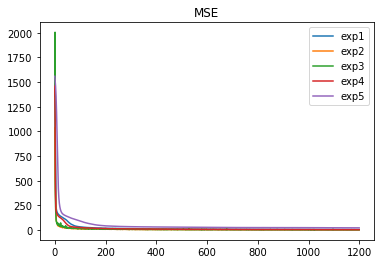

In [93]:
plt.plot(x,exp_1_r)
plt.plot(x,exp_2_r)
plt.plot(x,exp_3_r)
plt.plot(x,exp_4_r)
plt.plot(x,exp_5_r)
plt.legend(['exp1','exp2','exp3','exp4','exp5'])
plt.title("MSE")

## Analisis de los Resultados

Para este desarrollo se han realizado 5 experimentos, el primero se valido la arquitectura inicial, viendo que el ultimo valor en las 1200 iteraciones fue de 5.547, un buen resultado, utilizando la misma cantidad de neuronas y activadores, pero cambiando el optimizador a 'SGD', vemos una mejor reducción del error, en este caso podriamos concluir que en este modelo de red neuronal para regresion, el optimizador SGD es mejor que Adam.

Los experimentos 3 y 4 tratan de comprobar si es posible hacer un overfit aumentando el numero de neuronas, teniendo valores del error promedio en la ultima iteracion de 2.5 y 4.2.

Y el ultimo experimento, comprueba si es posible tener resultados similares reduciendo drasticamente el numero de las neuronas, a 24, obteniendo un MSE de 22, que en comparacion con el numero de neuronas de los experimentos anteriores, se puede aceptar.

## Modelo Convolucional

In [29]:
path_train = 'asl_sign_languaje/train'
path_test = 'asl_sign_languaje/test'

In [50]:
#%ls

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=False
)

In [31]:
train_generator = train_datagen.flow_from_directory(
    directory=path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 77971 images belonging to 26 classes.


In [32]:
test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

In [33]:
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 26 images belonging to 26 classes.


In [34]:
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
abecedario = [x for x in letters]

In [57]:
#pic = take_picture(30,"Capturando Letra A")

In [58]:
#for i in range(30):
#        #show_picture(pictures[i])
#    cv2.imwrite("{}/x{}_{}.jpg".format(path_train,letra,i),cv2.cvtColor(pic[i], cv2.COLOR_RGB2BGR))

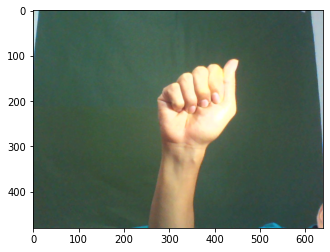

In [47]:
for i in range(30):
    show_picture(pic[i])

In [35]:
def show_picture(img, mapper=None):#opencv lee en BGR, matplotlib en RGB\n",
    if mapper:
        plt.imshow(img, cmap=mapper)
    else:
        plt.imshow(img)

In [56]:
#show_picture(pic[3])
#cv2.imwrite("test.jpg",cv2.cvtColor(pic[3], cv2.COLOR_RGB2BGR))

In [22]:
abde="abcde"

In [55]:
for letra in abde:
    pictures = take_picture(30,"Capturando Letra:{}".format(letra))
    for i in range(30):
        #show_picture(pictures[i])
        cv2.imwrite("{}/{}/x{}_{}.jpg".format(path_train,letra,letra,i),cv2.cvtColor(pictures[i], cv2.COLOR_RGB2BGR))
        #cv2.imwrite('{}/{}_{}.jpg'.format(path_train,letra*2,i),pictures[i])

In [36]:
def get_cam_picture(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

In [37]:
def take_picture(num_pics, text):
    cap = cv2.VideoCapture(0) #accesamos a la camara web
    count=0
    pictures = []
    while cap.isOpened():
        re, frame = cap.read()

        image = get_cam_picture(frame)
        
        pictures.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        count+=1
        
        cv2.rectangle(image, (0,0),(640,40), (245,117, 16), -1)
        cv2.putText(image, text, (3,30), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (255,255,255),2, cv2.LINE_AA)
        
        
        cv2.imshow("OpenCV Feed", image)
        time.sleep(0.5)
        
        if cv2.waitKey(10) & 0xFF == ord('q') or count>num_pics:
            break

    cap.release()

    cv2.destroyAllWindows()

    return pictures
        
        

In [189]:
cap.release()
cv2.destroyAllWindows()

In [38]:
def load_and_predict_img(np_image, modelo):
    #np_image = Image.open(filname)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224,224,3))
    np_image = np.expand_dims(np_image, axis=0)
    prediction = modelo.predict(np_image)

    return prediction

In [39]:
def get_conv_model(filters, kernels_size,pools_size, input_shape, activations, num_classes):
    #CNN
    cnn = Sequential()
    
    #primera capa de convoluciones
    cnn.add(Conv2D(filters=filters[0], kernel_size=kernels_size[0], input_shape=input_shape, activation=activations[0]))

    #primera capa de Max-Pooling
    cnn.add(MaxPool2D(pool_size=pools_size[0]))#,strides=(2, 2)

    #segunda capa de convoluciones
    cnn.add(Conv2D(filters=filters[1], kernel_size=kernels_size[1], activation=activations[1]))

    #capa de Max-Pooling
    cnn.add(MaxPool2D(pool_size=pools_size[1]))#,strides=(2, 2)
    
    #tercera capa de convoluciones
    #cnn.add(Conv2D(filters=filters[2], kernel_size=kernels_size[2], activation=activations[2]))

    #capa de Max-Pooling
    #cnn.add(MaxPool2D(pool_size=pools_size[2]))

    #capa flatten
    cnn.add(Flatten())

    #----------------- fase de artificial -----------------

    #primera capa oculta.
    cnn.add(Dense(units=1024, activation='relu'))

    #primera capa oculta.
    cnn.add(Dense(units=128, activation='relu'))
    
    #cnn.add(Dense(units=256, activation='relu'))
    
    #capa de salida.
    cnn.add(Dense(num_classes, activation='softmax'))
    
    return cnn

## Experimento 1

Este experimento va itentar obtener con x interaciones, la precision, se va probar optimizador adam, con dos capas convolucionales y dos capas densas. En las capas densas se va probar activacion relu.

In [74]:
filepath="conv_weights/exp_1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [76]:
cnn_1 = get_conv_model(filters=[64,32],kernels_size=[(3,3),(3,3)],pools_size=[(2,2),(2,2),(2,2)],
                        input_shape=(224,224,3), activations=['relu','relu'],num_classes=26)

cnn_1.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

cnn_1.fit(train_generator, steps_per_epoch=5, epochs=50,validation_data=test_generator)#validation_steps=800

Epoch 1/50
5/5 [==============================] - 7s 1s/step - loss: 4.2549 - accuracy: 0.0591 - val_loss: 3.2631 - val_accuracy: 0.0385
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 3.2597 - accuracy: 0.0347 - val_loss: 3.2574 - val_accuracy: 0.0385
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 3.2593 - accuracy: 0.0268 - val_loss: 3.2573 - val_accuracy: 0.0385
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 3.2574 - accuracy: 0.0710 - val_loss: 3.2554 - val_accuracy: 0.0769
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 3.2545 - accuracy: 0.0689 - val_loss: 3.2492 - val_accuracy: 0.0769
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 3.2560 - accuracy: 0.0590 - val_loss: 3.2472 - val_accuracy: 0.0385
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 3.2521 - accuracy: 0.0579 - val_loss: 3.2438 - val_accuracy: 0.0385
Epoch 8/50
5/5 [=========================

## Experimento 2

In [87]:
filepath="conv_weights/exp_2"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [88]:
cnn_2 = get_conv_model(filters=[64,32],kernels_size=[(3,3),(3,3)],pools_size=[(2,2),(2,2),(2,2)],
                       input_shape=(224,224,3), activations=['relu','relu'],num_classes=26)

In [92]:
# compile model
#$opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)

cnn_2.compile(optimizer="SGD", loss='categorical_crossentropy',  metrics=['accuracy'])
cnn_2.fit(train_generator, steps_per_epoch=5, epochs=50,validation_data=test_generator,callbacks=callbacks_list, verbose=1)#validation_steps=800


Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 3.2693 - accuracy: 0.0240 - val_loss: 3.2595 - val_accuracy: 0.0385

Epoch 00001: val_accuracy improved from -inf to 0.03846, saving model to conv_weights\exp_2
INFO:tensorflow:Assets written to: conv_weights\exp_2\assets
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 3.2634 - accuracy: 0.0351 - val_loss: 3.2557 - val_accuracy: 0.0385

Epoch 00002: val_accuracy did not improve from 0.03846
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 3.2529 - accuracy: 0.0443 - val_loss: 3.2545 - val_accuracy: 0.0385

Epoch 00003: val_accuracy did not improve from 0.03846
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 3.2697 - accuracy: 0.0402 - val_loss: 3.2528 - val_accuracy: 0.0769

Epoch 00004: val_accuracy improved from 0.03846 to 0.07692, saving model to conv_weights\exp_2
INFO:tensorflow:Assets written to: conv_weights\exp_2\assets
Epoch 5/50
5/5 [=============

## Experimento 3

In [40]:
filepath="conv_weights/exp_3"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [41]:
cnn_3 = get_conv_model(filters=[64,128],kernels_size=[(5,5),(3,3)],pools_size=[(2,2),(2,2),(2,2)],
                       input_shape=(224,224,3), activations=['relu','relu'],num_classes=26)

In [42]:
cnn_3.compile(optimizer="SGD", loss='categorical_crossentropy',  metrics=['accuracy'])
cnn_3.fit(train_generator, steps_per_epoch=60, epochs=20,validation_data=test_generator,verbose=1)##validation_steps=800


Epoch 1/20
60/60 [==============================] - 192s 3s/step - loss: 3.2663 - accuracy: 0.0326 - val_loss: 3.2308 - val_accuracy: 0.0769
Epoch 2/20
60/60 [==============================] - 200s 3s/step - loss: 3.2352 - accuracy: 0.0613 - val_loss: 3.1518 - val_accuracy: 0.1154
Epoch 3/20
60/60 [==============================] - 204s 3s/step - loss: 3.2101 - accuracy: 0.0704 - val_loss: 3.1131 - val_accuracy: 0.0769
Epoch 4/20
60/60 [==============================] - 202s 3s/step - loss: 3.1604 - accuracy: 0.0835 - val_loss: 2.8986 - val_accuracy: 0.1538
Epoch 5/20
60/60 [==============================] - 203s 3s/step - loss: 3.1219 - accuracy: 0.0864 - val_loss: 2.7864 - val_accuracy: 0.2308
Epoch 6/20
60/60 [==============================] - 192s 3s/step - loss: 3.0645 - accuracy: 0.1110 - val_loss: 2.6197 - val_accuracy: 0.1923
Epoch 7/20
60/60 [==============================] - 192s 3s/step - loss: 2.9636 - accuracy: 0.1515 - val_loss: 2.3964 - val_accuracy: 0.2692
Epoch 8/20
60

## Resultados 

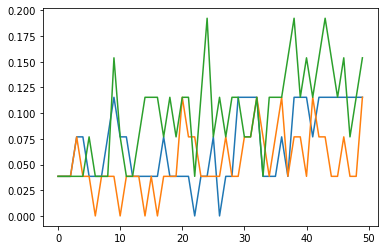

In [26]:
exp_1 = [0.0385,0.0385,0.0385,0.0769,0.0769,0.0385,0.0385,0.0385,0.0769,0.1154,0.0769,0.0769,0.0385,0.0385,0.0385,0.0385,0.0385,0.0769,0.0385,0.0385,0.0385,0.0385,0.0000e+00,0.0385,0.0385,0.0769,0.0000e+00,0.0385,0.0385,0.1154,0.1154,0.1154,0.1154,0.0385,0.0385,0.0385,0.0769,0.0385,0.1154,0.1154,0.1154,0.0769,0.1154,0.1154,0.1154,0.1154,0.1154,0.1154,0.1154, 0.1154]
exp_2 = [0.0385, 0.0385, 0.0385, 0.0769, 0.0385, 0.0385, 0.0000e+00, 0.0385, 0.0385, 0.0385, 0.0000e+00, 0.0385, 0.0385, 0.0385, 0.0000e+00, 0.0385, 0.0000e+00, 0.0385, 0.0385, 0.0385, 0.1154, 0.0769, 0.0769, 0.0385, 0.0385, 0.0385, 0.0385, 0.0769, 0.0385, 0.0385, 0.0769, 0.0769, 0.1154, 0.0769, 0.0385, 0.0769, 0.1154, 0.0385, 0.0769, 0.0769, 0.0385, 0.1154, 0.0769, 0.0769, 0.0385, 0.0385, 0.0769, 0.0385, 0.0385, 0.1154]
exp_3 = [0.0385,0.0385,0.0385,0.0385,0.0385,0.0769,0.0385,0.0385,0.0385,0.1538,0.0769,0.0385,0.0385,0.0769,0.1154,0.1154,0.1154,0.0769,0.1154,0.0769,0.1154,0.1154,0.0385,0.1154,0.1923,0.0769,0.1154,0.0769,0.1154,0.1154,0.0769,0.0769,0.1154,0.0385,0.1154,0.1154,0.1154,0.1538,0.1923,0.1154,0.1538,0.1154,0.1538,0.1923,0.1538,0.1154,0.1538,0.0769,0.1154,0.1538]
epochs_exp = [i for i in range(50)]

plt.plot(epochs_exp,exp_1)
plt.plot(epochs_exp,exp_2)
plt.plot(epochs_exp,exp_3)

## Testeando el lenguaje de Señas con la camara Web

In [44]:
#def test_model_with_cam(cnn):
#Test in Real Time
cnn = cnn_3
cap = cv2.VideoCapture(0) #accesamos a la camara web
sentence=['.']
umbral = 0.50

with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5)as holistic:
    while cap.isOpened():
        re, frame = cap.read()
        image = get_cam_picture(frame)

        try:
            prediction = load_and_predict_img(image,cnn)
            print(np.max(prediction),abecedario[np.argmax(prediction)])
            if np.max(prediction) > umbral:
                sentence.append(abecedario[np.argmax(prediction)])
        except:
            pass

        if len(sentence)>15:
            sentence = sentence[-15:]

        cv2.rectangle(image, (0,0),(640,40), (245,117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (255,255,255),2, cv2.LINE_AA)


        cv2.imshow("Test Sign Languaje in Real Time", image)
        time.sleep(0.5)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()

    cv2.destroyAllWindows()

0.6311499 S
0.10754982 B
0.19386761 P
0.18185551 S
0.14081322 S
0.21130629 P
0.15546341 S
0.13928533 S
0.08839184 D
0.10795549 A
0.10738013 A
0.103891596 A
0.09896742 A
0.081608824 U
0.09730982 C
0.116073206 C
0.076757945 U
0.0778025 U
0.075136706 U
0.0757068 U
0.07475012 U
0.092324466 U
0.10679661 U
0.089976475 B
0.09544337 B
0.093950085 B
0.07654657 U
0.09408444 B
0.095161095 B
0.09139165 B
0.08761404 B
0.08745169 B
0.08537624 B
0.09183423 B
0.09108277 U
0.09562709 U
0.09432689 B
0.08275626 U
0.09456724 A
0.099802114 A


In [ ]:
cap.release()
cv2.destroyAllWindows()

## Modelo Sequencial

In [45]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [46]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)#draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)#draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)#draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)#draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)#draw right hand connections

In [47]:
def draw_styled_landmark(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))#draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=1))#draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=1))#draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1))#draw right hand connections

In [48]:
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility]for res in results.pose_landmarks.landmark]).flatten()\
    if results.pose_landmarks else np.zeros(132)
    
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(1404)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()\
    if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose,face,lh,rh])
    

In [57]:
#Ruta para almacenar la data de entrenamiento
DATA_PATH = os.path.join("MP_Data")

#Acciones que se van a tratar de detectar
actions = np.array(['Hola','Gracias','TeQuiero'])

#30 videos
no_sequences = 30
sequence_length= 30

In [15]:
#Creacion de las carpetas para guardar la info
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except Exception as error:
            print(error)
            

[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\0'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\1'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\2'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\3'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\4'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\5'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\6'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\7'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\8'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\9'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\10'
[WinError 183] No se puede crear un archivo que ya existe: 'MP_Data\\Hola\\11'
[WinError 183] No se puede crear un archivo que ya existe: 'MP

## Guardando informacion para entrenar la RNN

In [38]:
def train_sign_defined():
    #Abrimos la camara Web
    cap = cv2.VideoCapture(0)
    # Configuramos el modelo 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # NEW LOOP
        # Loop through actions
        for action in actions:
            # Loop through sequences aka videos
            for sequence in range(no_sequences):

                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmark(image, results)

                    # NEW Apply wait logic
                    if frame_num == 0: 
                        cv2.putText(image, 'GUARDANDO COLECCION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Recogiendo frames para:{} Iteracion: {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('DEEP LEARNING', image)
                        cv2.waitKey(400)
                    else: 
                        cv2.putText(image, 'Recogiendo frames para:{} Iteracion: {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('DEEP LEARNING', image)

                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

        cap.release()
        cv2.destroyAllWindows()

In [14]:
#train_sign_defined()

In [60]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'Hola': 0, 'Gracias': 1, 'TeQuiero': 2}

In [61]:
#Cargamos la data almacenada en Disco
def load_data_from_disk():
    sequences, labels = [],[]
    for action in actions:
        for sequence in range(no_sequences):
            window = []

            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    return sequences,labels

In [62]:
secuencias, labels = load_data_from_disk()

In [63]:
y = to_categorical(labels).astype('int32')#one hot encoding
y.shape

(90, 3)

In [64]:
X = np.array(secuencias)
X.shape

(90, 30, 1662)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.05)

In [69]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [66]:
def return_sequential_model(optimizador, loss_fun, metricas):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation = 'relu', input_shape=(30,1662)))
    model.add(LSTM(128, return_sequences=True, activation = 'relu'))
    model.add(LSTM(64, return_sequences=False, activation = 'relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))
    
    model.compile(optimizer=optimizador, loss=loss_fun, metrics =[metricas])
    
    return model


In [67]:
sq_model = return_sequential_model('Adam','categorical_crossentropy', 'categorical_accuracy')
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['categorical_accuracy'])#

In [21]:
%ls Logs\train


 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 46CF-D87E

 Directorio de C:\Users\Usuario\anaconda3\envs\STL\Notebooks\Logs\train

24/09/2021  16:32    <DIR>          .
24/09/2021  16:32    <DIR>          ..
24/09/2021  16:05           957,046 events.out.tfevents.1632520714.RDC-C0152.12284.11121.v2
24/09/2021  15:58                40 events.out.tfevents.1632520721.RDC-C0152.profile-empty
24/09/2021  16:33           759,765 events.out.tfevents.1632522730.RDC-C0152.6424.82.v2
24/09/2021  15:58    <DIR>          plugins
               3 archivos      1,716,851 bytes
               3 dirs  73,707,655,168 bytes libres


In [22]:
%reload_ext tensorboard

In [23]:
logs_base_dir = "C:\\Users\\Usuario\\anaconda3\\envs\\STL\\Notebooks\\Logs\\train"


In [180]:
#%tensorboard dev upload --logdir logs_base_dir

In [27]:
#%tensorboard --logdir logs_base_dir --port 6006

In [72]:
sq_model.fit(x_train,y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 0s 141ms/step - loss: 2447.2969 - categorical_accuracy: 0.3294
Epoch 2/500
3/3 [==============================] - 0s 67ms/step - loss: 1808.2427 - categorical_accuracy: 0.2824
Epoch 3/500
3/3 [==============================] - 0s 69ms/step - loss: 1699.0219 - categorical_accuracy: 0.3412
Epoch 4/500
3/3 [==============================] - 0s 63ms/step - loss: 1441.0417 - categorical_accuracy: 0.3176
Epoch 5/500
3/3 [==============================] - 0s 72ms/step - loss: 2387.6829 - categorical_accuracy: 0.3529
Epoch 6/500
3/3 [==============================] - 0s 83ms/step - loss: 1682.1526 - categorical_accuracy: 0.3294
Epoch 7/500
3/3 [==============================] - 0s 69ms/step - loss: 1918.8812 - categorical_accuracy: 0.3294
Epoch 8/500
3/3 [==============================] - 0s 68ms/step - loss: 1281.7643 - categorical_accuracy: 0.3176
Epoch 9/500
3/3 [==============================] - 0s 73ms/step - loss: 658.4054 - categorical_

In [73]:
#sq_model.save('best_seq.h5')
sq_model

In [2]:
#new_model_seqq.load('test')

## Pruebas en Tiempo Real

In [74]:
sequence = []
sentence = []
threshold = 0.5

In [77]:
#def test_in_real_time(model,sequence,sentence,threshold):
cap = cv2.VideoCapture(0) #accesamos a la camara web

with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5)as holistic:
    while cap.isOpened():
        re, frame = cap.read()

        image, results = mediapipe_detection(frame,holistic)

        draw_styled_landmark(image,results)

        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]

        if len(sequence)==30:
            res=sq_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            #3) Viz Logic
            if res[np.argmax(res)] >threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

        if len(sentence)>5:
            sentence = sentence[-5:]

        cv2.rectangle(image, (0,0),(640,40), (245,117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (255,255,255),2, cv2.LINE_AA)


        cv2.imshow("SIGN LANGUAJE DETECT", image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()

    cv2.destroyAllWindows()

Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias
Gracias


In [76]:
cap.release()
cv2.destroyAllWindows()

In [20]:
model = keras.models.load_model('test')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 30, 64)            0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 30, 128)           0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 6,339
Trainable params: 6,339
Non-trainable params: 0
______________________________________________________